In [ ]:
import albumentations as A
import cv2

transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

root = '/content/drive/MyDrive/torch_ds/data/val'
train_folders = os.listdir(root)
for folder in train_folders:

  fold_path = os.path.join(root, folder)
  files_in_folder = os.listdir(fold_path)
  files_in_folder = [file_ for file_ in files_in_folder if os.path.isfile(os.path.join(fold_path, file_))]

  n = 2

  for file_ in files_in_folder:
    file_path = os.path.join(fold_path, file_)
    print(file_path)

    for i in range(n):
      try:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        aug_image = transform(image=image)['image']
        aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        new_path = os.path.join(fold_path, f'aug_{i}_{file_}')
        print(new_path)
        cv2.imwrite(new_path, aug_image)

      except Exception:
        print('ERR!')
        continue

In [1]:
!nvidia-smi

Mon Feb 27 13:52:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import torch
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import os
import json

/home/zeinovich/venvs/catfinder/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn


In [57]:
model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT, progress=True)

In [58]:
for param in model.parameters():
    param.requires_grad = False

In [59]:
model.classifier =nn.Sequential(
                          nn.Dropout(p=0.3, inplace=True),
                          nn.Linear(in_features=1408, out_features=13, bias=True)
                              )
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=13, bias=True)
)

In [49]:
data_dir = '/content/drive/MyDrive/torch_ds/data/train'

In [3]:
from torchvision import datasets, transforms

In [50]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_images = datasets.ImageFolder(data_dir, transform=transform)


In [55]:
train_images

Dataset ImageFolder
    Number of datapoints: 14649
    Root location: /content/drive/MyDrive/torch_ds/data/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [56]:
train_loader = torch.utils.data.DataLoader(train_images,
                                            batch_size=32, shuffle=True, drop_last=True, 
                                            num_workers=8)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
data_dir = '/content/drive/MyDrive/torch_ds/data/val'

val_images = datasets.ImageFolder(data_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_images,
                                          batch_size=32, shuffle=True, drop_last=True,
                                          num_workers=4)
val_images


Dataset ImageFolder
    Number of datapoints: 2001
    Root location: /content/drive/MyDrive/torch_ds/data/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [36]:
data_dir = '/content/drive/MyDrive/torch_ds/data/test'

test_images = datasets.ImageFolder(data_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_images,
                                          batch_size=32, 
                                          num_workers=4, 
                                          shuffle=True,
                                          drop_last=True)
test_images

Dataset ImageFolder
    Number of datapoints: 625
    Root location: /content/drive/MyDrive/torch_ds/data/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
import time
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import numpy as np

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss + self.min_delta < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss >= self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
                
        return False

In [6]:
from tqdm import tqdm

In [20]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, early_stopper, num_epochs=25, num_classes=1):
  
    since = time.perf_counter()

    val_acc_history = []
    val_loss_history = []

    lengths = {}
    for phase in ['train', 'val']:
        lengths[phase] = len(dataloaders[phase].dataset)
        print(f'{phase}_iters: {lengths[phase] // 32}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            lr = scheduler.optimizer.param_groups[0]['lr']
            running_loss = 0.0
            running_corrects = 0
            running_accuracy = 0.0

            with tqdm(dataloaders[phase], unit="batch", miniters=1) as tepoch:
                iter = 0
                for inputs, labels in tepoch:
                    iter += 1
                    if phase == 'train':
                        tepoch.set_description(f"Epoch {epoch + 1}")
                    else:
                        tepoch.set_description(f"Validation {epoch + 1}")

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = labels.type(torch.int64)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(torch.softmax(outputs, 1), 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
                    running_accuracy = running_corrects / (iter * 32)
                    tepoch.set_postfix(loss=loss.item(), accuracy=running_accuracy.item())

                epoch_loss = running_loss / lengths[phase]
                epoch_acc = running_corrects.double() / lengths[phase]

                print(f'{phase}_loss: {epoch_loss:.4f} {phase}_acc: {epoch_acc:.4f}')

                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        
                    if min_loss - epoch_loss >= early_stopper.min_delta:
                        min_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        torch.save({'epoch': epoch, 
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'loss': epoch_loss}, '/content/drive/MyDrive/models/efnet_b2.tar')

                    scheduler.step(epoch_loss)
                    val_acc_history.append(epoch_acc)
                    val_loss_history.append(epoch_loss)
                    print(f"lr: {lr:.0E}  min_loss: {min_loss:.4f}")

        epoch_end = time.perf_counter()
        time_elapsed =  epoch_end - epoch_start

        print(f'Epoch {epoch + 1} took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if early_stopper.early_stop(epoch_loss):             
            break
        
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val_acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

In [21]:
import torch.optim as optim

In [40]:
for name, param in model.named_parameters():
      if param.requires_grad == True:
          print("\t",name)

	 classifier.1.weight
	 classifier.1.bias


In [60]:
adam = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=0.1, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adam, patience=3, factor=0.1, threshold=1e-2, min_lr=1e-9)
criterion = nn.CrossEntropyLoss(label_smoothing=1e-2)
e_s = EarlyStopper(patience=10, min_delta=1e-2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [42]:
train_images.class_to_idx

{'0neg': 0,
 'Abyssinian': 1,
 'Bengal': 2,
 'Birman': 3,
 'Bombay': 4,
 'British_Shorthair': 5,
 'Egyptian_Mau': 6,
 'Maine_Coon': 7,
 'Persian': 8,
 'Ragdoll': 9,
 'Russian_Blue': 10,
 'Siamese': 11,
 'Sphynx': 12}

In [28]:
import json
breed_dict = train_images.class_to_idx
breed_dict = {value: key.replace('_', ' ') for key, value in breed_dict.items()}
print(breed_dict)
with open('/content/drive/MyDrive/torch_ds/data/breed_dict.json', 'w') as f:
    json.dump(breed_dict, f, indent=4)

{0: '0neg', 1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British Shorthair', 6: 'Egyptian Mau', 7: 'Maine Coon', 8: 'Persian', 9: 'Ragdoll', 10: 'Russian Blue', 11: 'Siamese', 12: 'Sphynx'}


In [61]:
model = model.to(device)
model, val_acc_his, val_loss_his = train_model(model, dataloaders, criterion, adam, scheduler,
            e_s, num_classes=13, num_epochs=50)

train_iters: 457
val_iters: 62


Epoch 1: 100%|██████████| 457/457 [21:26<00:00,  2.81s/batch, accuracy=0.781, loss=0.654]


train_loss: 0.8561 train_acc: 0.7799


Validation 1: 100%|██████████| 62/62 [00:22<00:00,  2.73batch/s, accuracy=0.892, loss=0.549]


val_loss: 0.5042 val_acc: 0.8841
lr: 1E-03  min_loss: 0.5042
Epoch 1 took 21m 51s



Epoch 2: 100%|██████████| 457/457 [02:15<00:00,  3.38batch/s, accuracy=0.857, loss=0.559]


train_loss: 0.5279 train_acc: 0.8551


Validation 2: 100%|██████████| 62/62 [00:21<00:00,  2.90batch/s, accuracy=0.899, loss=0.58]


val_loss: 0.4295 val_acc: 0.8916
lr: 1E-03  min_loss: 0.4295
Epoch 2 took 2m 37s



Epoch 3: 100%|██████████| 457/457 [02:12<00:00,  3.46batch/s, accuracy=0.879, loss=0.552]


train_loss: 0.4641 train_acc: 0.8773


Validation 3: 100%|██████████| 62/62 [00:22<00:00,  2.81batch/s, accuracy=0.908, loss=0.197]


val_loss: 0.3879 val_acc: 0.9005
lr: 1E-03  min_loss: 0.3879
Epoch 3 took 2m 35s



Epoch 4: 100%|██████████| 457/457 [02:13<00:00,  3.42batch/s, accuracy=0.885, loss=0.725]


train_loss: 0.4435 train_acc: 0.8832


Validation 4: 100%|██████████| 62/62 [00:20<00:00,  3.00batch/s, accuracy=0.902, loss=0.379]


val_loss: 0.4024 val_acc: 0.8941
lr: 1E-03  min_loss: 0.3879
Epoch 4 took 2m 34s



Epoch 5: 100%|██████████| 457/457 [02:12<00:00,  3.46batch/s, accuracy=0.888, loss=0.344]


train_loss: 0.4215 train_acc: 0.8865


Validation 5: 100%|██████████| 62/62 [00:22<00:00,  2.74batch/s, accuracy=0.901, loss=0.24]


val_loss: 0.3799 val_acc: 0.8936
lr: 1E-03  min_loss: 0.3879
Epoch 5 took 2m 35s



Epoch 6: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.891, loss=0.175]


train_loss: 0.4119 train_acc: 0.8895


Validation 6: 100%|██████████| 62/62 [00:20<00:00,  3.01batch/s, accuracy=0.911, loss=0.476]


val_loss: 0.3581 val_acc: 0.9030
lr: 1E-03  min_loss: 0.3581
Epoch 6 took 2m 34s



Epoch 7: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.896, loss=0.345]


train_loss: 0.4046 train_acc: 0.8947


Validation 7: 100%|██████████| 62/62 [00:22<00:00,  2.76batch/s, accuracy=0.902, loss=0.463]


val_loss: 0.3727 val_acc: 0.8941
lr: 1E-03  min_loss: 0.3581
Epoch 7 took 2m 36s



Epoch 8: 100%|██████████| 457/457 [02:13<00:00,  3.42batch/s, accuracy=0.896, loss=0.456]


train_loss: 0.3999 train_acc: 0.8943


Validation 8: 100%|██████████| 62/62 [00:20<00:00,  3.01batch/s, accuracy=0.903, loss=0.349]


val_loss: 0.3775 val_acc: 0.8951
lr: 1E-03  min_loss: 0.3581
Epoch 8 took 2m 34s



Epoch 9: 100%|██████████| 457/457 [02:13<00:00,  3.42batch/s, accuracy=0.899, loss=0.353]


train_loss: 0.3898 train_acc: 0.8974


Validation 9: 100%|██████████| 62/62 [00:22<00:00,  2.75batch/s, accuracy=0.905, loss=0.452]


val_loss: 0.3711 val_acc: 0.8971
lr: 1E-03  min_loss: 0.3581
Epoch 9 took 2m 36s



Epoch 10: 100%|██████████| 457/457 [02:12<00:00,  3.44batch/s, accuracy=0.901, loss=0.238]


train_loss: 0.3926 train_acc: 0.8993


Validation 10: 100%|██████████| 62/62 [00:20<00:00,  2.97batch/s, accuracy=0.904, loss=0.32]


val_loss: 0.3692 val_acc: 0.8961
lr: 1E-03  min_loss: 0.3581
Epoch 10 took 2m 34s



Epoch 11: 100%|██████████| 457/457 [02:13<00:00,  3.42batch/s, accuracy=0.906, loss=0.529]


train_loss: 0.3664 train_acc: 0.9042


Validation 11: 100%|██████████| 62/62 [00:22<00:00,  2.75batch/s, accuracy=0.911, loss=0.283]


val_loss: 0.3468 val_acc: 0.9035
lr: 1E-04  min_loss: 0.3468
Epoch 11 took 2m 36s



Epoch 12: 100%|██████████| 457/457 [02:12<00:00,  3.44batch/s, accuracy=0.904, loss=0.407]


train_loss: 0.3709 train_acc: 0.9028


Validation 12: 100%|██████████| 62/62 [00:21<00:00,  2.91batch/s, accuracy=0.902, loss=0.299]


val_loss: 0.3760 val_acc: 0.8946
lr: 1E-04  min_loss: 0.3468
Epoch 12 took 2m 34s



Epoch 13: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.906, loss=0.426]


train_loss: 0.3736 train_acc: 0.9042


Validation 13: 100%|██████████| 62/62 [00:21<00:00,  2.90batch/s, accuracy=0.909, loss=0.229]


val_loss: 0.3557 val_acc: 0.9010
lr: 1E-04  min_loss: 0.3468
Epoch 13 took 2m 34s



Epoch 14: 100%|██████████| 457/457 [02:11<00:00,  3.47batch/s, accuracy=0.909, loss=0.563]


train_loss: 0.3640 train_acc: 0.9079


Validation 14: 100%|██████████| 62/62 [00:22<00:00,  2.78batch/s, accuracy=0.911, loss=0.322]


val_loss: 0.3578 val_acc: 0.9030
lr: 1E-04  min_loss: 0.3468
Epoch 14 took 2m 34s



Epoch 15: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.908, loss=0.309]


train_loss: 0.3696 train_acc: 0.9066


Validation 15: 100%|██████████| 62/62 [00:20<00:00,  3.00batch/s, accuracy=0.906, loss=0.301]


val_loss: 0.3525 val_acc: 0.8986
lr: 1E-04  min_loss: 0.3468
Epoch 15 took 2m 34s



Epoch 16: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.908, loss=0.352]


train_loss: 0.3635 train_acc: 0.9065


Validation 16: 100%|██████████| 62/62 [00:22<00:00,  2.73batch/s, accuracy=0.908, loss=0.391]


val_loss: 0.3610 val_acc: 0.9000
lr: 1E-05  min_loss: 0.3468
Epoch 16 took 2m 36s



Epoch 17: 100%|██████████| 457/457 [02:12<00:00,  3.44batch/s, accuracy=0.909, loss=0.224]


train_loss: 0.3628 train_acc: 0.9070


Validation 17: 100%|██████████| 62/62 [00:20<00:00,  2.97batch/s, accuracy=0.909, loss=0.485]


val_loss: 0.3586 val_acc: 0.9015
lr: 1E-05  min_loss: 0.3468
Epoch 17 took 2m 34s



Epoch 18: 100%|██████████| 457/457 [02:13<00:00,  3.43batch/s, accuracy=0.903, loss=0.478]


train_loss: 0.3720 train_acc: 0.9012


Validation 18: 100%|██████████| 62/62 [00:22<00:00,  2.82batch/s, accuracy=0.911, loss=0.359]


val_loss: 0.3463 val_acc: 0.9030
lr: 1E-05  min_loss: 0.3468
Epoch 18 took 2m 35s



Epoch 19: 100%|██████████| 457/457 [02:14<00:00,  3.41batch/s, accuracy=0.907, loss=0.321]


train_loss: 0.3681 train_acc: 0.9059


Validation 19: 100%|██████████| 62/62 [00:21<00:00,  2.93batch/s, accuracy=0.911, loss=0.338]


val_loss: 0.3498 val_acc: 0.9035
lr: 1E-05  min_loss: 0.3468
Epoch 19 took 2m 35s



Epoch 20: 100%|██████████| 457/457 [02:13<00:00,  3.41batch/s, accuracy=0.909, loss=0.249]


train_loss: 0.3603 train_acc: 0.9070


Validation 20: 100%|██████████| 62/62 [00:21<00:00,  2.84batch/s, accuracy=0.91, loss=0.329]


val_loss: 0.3501 val_acc: 0.9020
lr: 1E-06  min_loss: 0.3468
Epoch 20 took 2m 36s



Epoch 21: 100%|██████████| 457/457 [02:14<00:00,  3.40batch/s, accuracy=0.913, loss=0.42]


train_loss: 0.3584 train_acc: 0.9117


Validation 21: 100%|██████████| 62/62 [00:21<00:00,  2.88batch/s, accuracy=0.907, loss=0.233]


val_loss: 0.3588 val_acc: 0.8996
lr: 1E-06  min_loss: 0.3468
Epoch 21 took 2m 36s



Epoch 22: 100%|██████████| 457/457 [02:17<00:00,  3.33batch/s, accuracy=0.909, loss=0.553]


train_loss: 0.3638 train_acc: 0.9075


Validation 22: 100%|██████████| 62/62 [00:22<00:00,  2.70batch/s, accuracy=0.911, loss=0.427]


val_loss: 0.3624 val_acc: 0.9035
lr: 1E-06  min_loss: 0.3468
Epoch 22 took 2m 40s



Epoch 23: 100%|██████████| 457/457 [02:15<00:00,  3.37batch/s, accuracy=0.91, loss=0.322]


train_loss: 0.3606 train_acc: 0.9089


Validation 23: 100%|██████████| 62/62 [00:21<00:00,  2.95batch/s, accuracy=0.906, loss=0.642]


val_loss: 0.3642 val_acc: 0.8981
lr: 1E-06  min_loss: 0.3468
Epoch 23 took 2m 37s



Epoch 24: 100%|██████████| 457/457 [02:15<00:00,  3.38batch/s, accuracy=0.91, loss=0.451]


train_loss: 0.3627 train_acc: 0.9085


Validation 24: 100%|██████████| 62/62 [00:22<00:00,  2.71batch/s, accuracy=0.911, loss=0.305]


val_loss: 0.3564 val_acc: 0.9030
lr: 1E-07  min_loss: 0.3468
Epoch 24 took 2m 38s



Epoch 25: 100%|██████████| 457/457 [02:15<00:00,  3.37batch/s, accuracy=0.911, loss=0.18]


train_loss: 0.3599 train_acc: 0.9090


Validation 25: 100%|██████████| 62/62 [00:21<00:00,  2.88batch/s, accuracy=0.915, loss=0.308]


val_loss: 0.3517 val_acc: 0.9070
lr: 1E-07  min_loss: 0.3468
Epoch 25 took 2m 37s



Epoch 26: 100%|██████████| 457/457 [02:16<00:00,  3.35batch/s, accuracy=0.911, loss=0.351]


train_loss: 0.3656 train_acc: 0.9094


Validation 26: 100%|██████████| 62/62 [00:21<00:00,  2.86batch/s, accuracy=0.909, loss=0.206]


val_loss: 0.3507 val_acc: 0.9015
lr: 1E-07  min_loss: 0.3468
Epoch 26 took 2m 38s



Epoch 27: 100%|██████████| 457/457 [02:15<00:00,  3.37batch/s, accuracy=0.91, loss=0.403]


train_loss: 0.3647 train_acc: 0.9080


Validation 27: 100%|██████████| 62/62 [00:22<00:00,  2.73batch/s, accuracy=0.91, loss=0.348]


val_loss: 0.3553 val_acc: 0.9020
lr: 1E-07  min_loss: 0.3468
Epoch 27 took 2m 38s



Epoch 28: 100%|██████████| 457/457 [02:17<00:00,  3.33batch/s, accuracy=0.91, loss=0.296]


train_loss: 0.3689 train_acc: 0.9085


Validation 28: 100%|██████████| 62/62 [00:21<00:00,  2.91batch/s, accuracy=0.911, loss=0.518]


val_loss: 0.3505 val_acc: 0.9035
lr: 1E-08  min_loss: 0.3468
Epoch 28 took 2m 39s



Epoch 29: 100%|██████████| 457/457 [02:16<00:00,  3.35batch/s, accuracy=0.912, loss=0.513]


train_loss: 0.3655 train_acc: 0.9102


Validation 29: 100%|██████████| 62/62 [00:22<00:00,  2.70batch/s, accuracy=0.904, loss=0.348]


val_loss: 0.3638 val_acc: 0.8961
lr: 1E-08  min_loss: 0.3468
Epoch 29 took 2m 39s



Epoch 30: 100%|██████████| 457/457 [02:15<00:00,  3.37batch/s, accuracy=0.908, loss=0.36]


train_loss: 0.3627 train_acc: 0.9064


Validation 30: 100%|██████████| 62/62 [00:21<00:00,  2.90batch/s, accuracy=0.911, loss=0.489]


val_loss: 0.3533 val_acc: 0.9035
lr: 1E-08  min_loss: 0.3468
Epoch 30 took 2m 37s



Epoch 31: 100%|██████████| 457/457 [02:16<00:00,  3.35batch/s, accuracy=0.908, loss=0.531]


train_loss: 0.3670 train_acc: 0.9061


Validation 31: 100%|██████████| 62/62 [00:21<00:00,  2.90batch/s, accuracy=0.907, loss=0.549]


val_loss: 0.3671 val_acc: 0.8991
lr: 1E-08  min_loss: 0.3468
Epoch 31 took 2m 38s



Epoch 32: 100%|██████████| 457/457 [02:15<00:00,  3.37batch/s, accuracy=0.909, loss=0.481]


train_loss: 0.3655 train_acc: 0.9074


Validation 32: 100%|██████████| 62/62 [00:23<00:00,  2.63batch/s, accuracy=0.912, loss=0.264]


val_loss: 0.3484 val_acc: 0.9040
lr: 1E-08  min_loss: 0.3468
Epoch 32 took 2m 39s



Epoch 33: 100%|██████████| 457/457 [02:16<00:00,  3.34batch/s, accuracy=0.909, loss=0.232]


train_loss: 0.3613 train_acc: 0.9077


Validation 33: 100%|██████████| 62/62 [00:21<00:00,  2.91batch/s, accuracy=0.91, loss=0.327]


val_loss: 0.3546 val_acc: 0.9020
lr: 1E-08  min_loss: 0.3468
Epoch 33 took 2m 38s



Epoch 34: 100%|██████████| 457/457 [02:15<00:00,  3.36batch/s, accuracy=0.908, loss=0.442]


train_loss: 0.3667 train_acc: 0.9064


Validation 34: 100%|██████████| 62/62 [00:21<00:00,  2.84batch/s, accuracy=0.909, loss=0.469]


val_loss: 0.3485 val_acc: 0.9010
lr: 1E-08  min_loss: 0.3468
Epoch 34 took 2m 38s



Epoch 35: 100%|██████████| 457/457 [02:16<00:00,  3.36batch/s, accuracy=0.909, loss=0.284]


train_loss: 0.3639 train_acc: 0.9074


Validation 35: 100%|██████████| 62/62 [00:22<00:00,  2.77batch/s, accuracy=0.915, loss=0.228]


val_loss: 0.3465 val_acc: 0.9070
lr: 1E-08  min_loss: 0.3468
Epoch 35 took 2m 38s



Epoch 36: 100%|██████████| 457/457 [02:16<00:00,  3.34batch/s, accuracy=0.908, loss=0.259]


train_loss: 0.3646 train_acc: 0.9065


Validation 36: 100%|██████████| 62/62 [00:20<00:00,  2.96batch/s, accuracy=0.912, loss=0.195]


val_loss: 0.3523 val_acc: 0.9040
lr: 1E-08  min_loss: 0.3468
Epoch 36 took 2m 38s



Epoch 37: 100%|██████████| 457/457 [02:15<00:00,  3.38batch/s, accuracy=0.91, loss=0.634]


train_loss: 0.3596 train_acc: 0.9087


Validation 37: 100%|██████████| 62/62 [00:22<00:00,  2.73batch/s, accuracy=0.909, loss=0.809]


val_loss: 0.3611 val_acc: 0.9015
lr: 1E-08  min_loss: 0.3468
Epoch 37 took 2m 38s
Training complete in 115m 41s
Best val_acc: 0.907046


In [62]:
def test_model(model, test_dataloader, criterion):
    model.eval()

    since = time.perf_counter()

    running_loss = 0.0
    running_corrects = 0
    all_preds = np.array([])
    all_labels = np.array([])

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.int64)

        with torch.no_grad():  
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(torch.softmax(outputs, 1), 1)
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(torch.round(preds)==labels.data)

        labels = labels.to(torch.device('cpu'))
        preds = preds.to(torch.device('cpu'))

        labels_np = labels.detach().numpy()
        labels_np = np.reshape(labels_np, -1)
        all_labels = np.append(all_labels, labels_np, axis=0)

        preds_np = preds.detach().numpy()
        preds_np = np.reshape(preds_np, -1)
        all_preds = np.append(all_preds, preds_np, axis=0)

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}\n')

    print(f'Tested in {(time.perf_counter() - since):.1f}s')
    
    return all_preds, all_labels

In [63]:
checkpoint = torch.load('/content/drive/MyDrive/models/efnet_b2.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [64]:
model = model.to(device)

In [65]:
all_preds, all_labels = test_model(model, test_loader, nn.CrossEntropyLoss())

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

breed_dict = test_images.class_to_idx

test_loss: 0.1515 test_acc: 0.9296

Tested in 121.1s


                       precision    recall  f1-score   support

             (0neg) 0       0.99      0.99      0.99       371
       (Abyssinian) 1       0.94      0.85      0.89        20
           (Bengal) 2       0.78      0.90      0.84        20
           (Birman) 3       0.69      0.90      0.78        20
           (Bombay) 4       0.90      1.00      0.95        19
(British_Shorthair) 5       1.00      0.90      0.95        20
     (Egyptian_Mau) 6       0.95      0.90      0.92        20
       (Maine_Coon) 7       0.94      0.85      0.89        20
          (Persian) 8       1.00      1.00      1.00        18
          (Ragdoll) 9       0.87      0.65      0.74        20
    (Russian_Blue) 10       0.83      0.95      0.88        20
         (Siamese) 11       1.00      0.90      0.95        20
          (Sphynx) 12       0.95      0.95      0.95        20

             accuracy                           0.96       608
            macro avg       0.91      0.90      0.90 

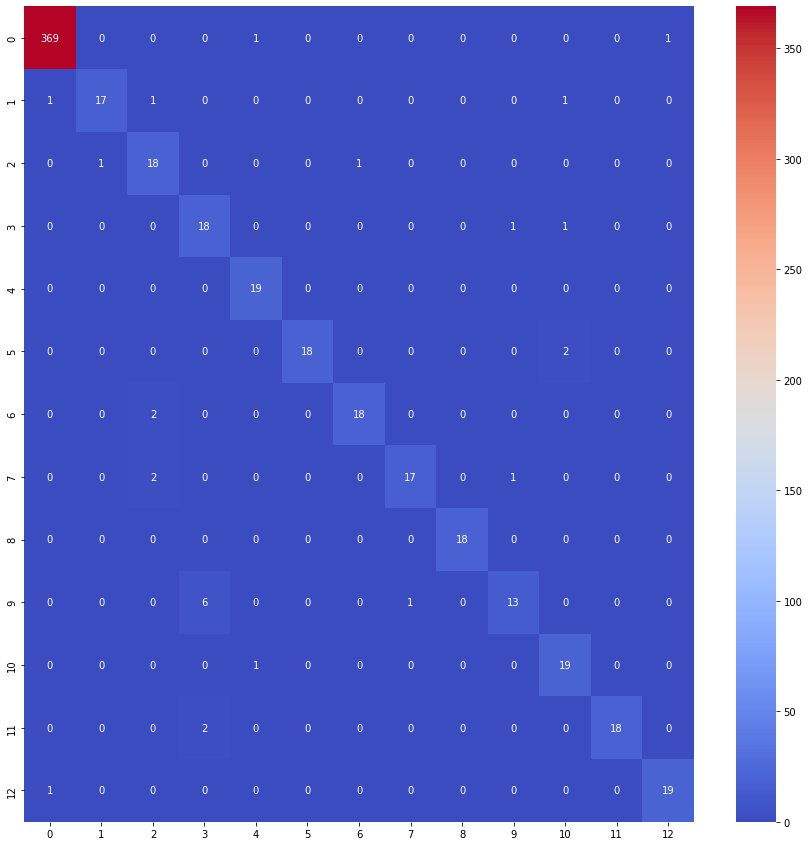

In [66]:
targets = [f'({key}) {value}' for key, value in breed_dict.items()]

print(classification_report(all_labels, all_preds, target_names=targets))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


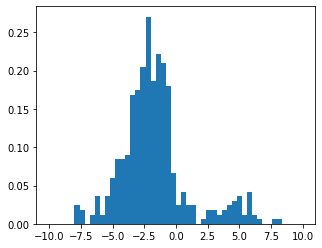

In [67]:
inputs, _ = next(iter(test_loader))
inputs = inputs.to(device)

with torch.no_grad():  
  outputs = model(inputs)

outputs = outputs.view(-1, 1)
outputs = outputs.detach().cpu().numpy()


plt.figure(figsize=(5, 4))
plt.hist(outputs, 50, density=True, range=(-10, 10))
plt.show()